In [6]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.art3d as art3d
from scipy.optimize import curve_fit

import torch
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.random.manual_seed(42)

random.seed(42)

class Cylinder(object):
    def __init__(self, radius=None, height=None, x=None, y=None, radial_posn=None, angular_posn=None, axial_posn=None, subunits=None, objid=None, num_objs=None):
        self.radius = radius
        self.height = height
        self.volume = math.pi * height * radius**2
        if not any([radial_posn, angular_posn]) and x is not None and y is not None:
            self.radial_posn = math.sqrt(x**2 + y**2)
            self.angular_posn = math.atan(y/x)
        else:
            self.radial_posn = radial_posn
            self.angular_posn = angular_posn
        if not any([x, y]) and radial_posn is not None and angular_posn is not None:
            self.x = radial_posn * math.cos(angular_posn)
            self.y = radial_posn * math.sin(angular_posn)
        else:
            self.x = x
            self.y = y
        self.axial_posn = axial_posn
        self.objid = objid if objid is not None else 0 # object id number
        self.num_objs = num_objs if num_objs is not None else 0 # NOT the current number of subunits; rather, the number of subunits that have belonged to this object
        if subunits is not None:
            self.subunits = subunits
        else:
            self.subunits = []
        
    def set_radius(self, R):
        self.radius = R
        
    def set_height(self, L):
        self.height = L
        
    def set_radial_posn(self, r):
        self.radial_posn = r
        if self.angular_posn is not None and self.x is None and self.y is None:
            self.x = self.radial_posn * np.cos(self.angular_posn)
            self.y = self.radial_posn * np.sin(self.angular_posn)
            
    def set_angular_posn(self, theta):
        self.angular_posn = theta
        if self.radial_posn is not None and self.x is None and self.y is None:
            self.x = self.radial_posn * np.cos(self.angular_posn)
            self.y = self.radial_posn * np.sin(self.angular_posn)
        
    def set_axial_posn(self, z):
        self.axial_posn = z
        
    # does the radial extent of this cylinder overlap with the radial extent of cylinder C?
    def radial_overlap(self, C):
        return (self.radial_posn - self.radius < C.radial_posn - C.radius < self.radial_posn + self.radius
                or self.radial_posn - self.radius < C.radial_posn + C.radius < self.radial_posn + self.radius
                or C.radial_posn - C.radius < self.radial_posn - self.radius < C.radial_posn + C.radius
                or C.radial_posn - C.radius < self.radial_posn + self.radius < C.radial_posn + C.radius)
    
    # does the angular extent of this cylinder overlap with the angular extent of cylinder C?
    def angular_overlap(self, C):
        dist = math.sqrt( (self.x - C.x)**2 + (self.y - C.y)**2 )
        return (dist <= self.radius - C.radius
                or dist <= C.radius - self.radius
                or dist < self.radius + C.radius
                or dist == self.radius + C.radius)
    
    # does the axial extent of this cylinder overlap with the axial extent of cylinder C?
    def axial_overlap(self, C):
        return (C.axial_posn < self.axial_posn + self.height < C.axial_posn + C.height
                or C.axial_posn < self.axial_posn < C.axial_posn + C.height
                or self.axial_posn < C.axial_posn + C.height < self.axial_posn + self.height
                or self.axial_posn < C.axial_posn < self.axial_posn + self.height)
    
    def add_subunits(self, S: list):
        for unit in S:
            if len(self.subunits) == 0 \
            and unit.radial_posn + unit.radius <= self.radius and unit.axial_posn + unit.height <= self.height:
                # increment num_objs
                self.num_objs += 1
                # assign new objid
                unit.objid = 1
                self.subunits.append(unit)
            elif unit.radial_posn + unit.radius <= self.radius and unit.axial_posn + unit.height <= self.height \
            and not any([unit.angular_overlap(other_unit) and unit.axial_overlap(other_unit) for other_unit in self.subunits]):
                # increment num_objs
                self.num_objs += 1
                # assign new objid
                unit.objid = self.num_objs
                self.subunits.append(unit)
                
    def remove_subunit(self, rm_objid: int):
        # rm_objid: the object id to search and remove from subunits
        # do not change num_objs
        self.subunits = list(filter(lambda u: u.objid != rm_objid, self.subunits))
    
    def pack(self, num_attempts=10):
        attempts = 1
        while attempts <= num_attempts:
            new_radius = 1 #random.uniform(0.5, 2)
            new_height = 5 #random.randint(5, 10)
            new_unit = Cylinder(radius=new_radius, height=new_height,
                                radial_posn=random.uniform(0, self.radius - new_radius),
                                angular_posn=random.uniform(0, 2*np.pi),
                                axial_posn=random.uniform(0, self.height - new_height))
            self.add_subunits([new_unit])
            attempts += 1
    
    def pack_torch(self, N_MTs=10):
        r = torch.rand((5, N_MTs)).to(device)
        r[:,3] = r[:,3] * (1 - (0.000001 + 0.02271689815195462)) + (0.000001 + 0.02271689815195462) # acceptable height sampling limits
        posns = torch.empty_like(r)
        posns[:,0] = 2 * self.radius * r[:,0] - self.radius # x
        posns[:,1] = 2 * self.radius * r[:,1] - self.radius # y
        posns[:,3] = -torch.log((r[:,3] - 0.02271689815195462)/1.3867234911412691) / 0.3758214593880463 # height
        posns[:,2] = r[:,2] * (self.height - posns[:,3]) # z (axial_posn)
        posns[:,4] = 14 - 2 * r[:,4] # radius

        # for checking if current subunits overlap:
        #posns = torch.tensor([(m.x, m.y, m.z, m.z + m.height, m.radius) for m in self.subunits])
        ids = torch.arange(N_MTs)#len(self.subunits))
        ids_pairs = torch.combinations(ids, 2).to(device)

        x_pairs = torch.stack([posns[0][ids_pairs[:,0]], posns[0][ids_pairs[:,1]]]).T
        y_pairs = torch.stack([posns[1][ids_pairs[:,0]], posns[1][ids_pairs[:,1]]]).T
        z_pairs = torch.stack([posns[2][ids_pairs[:,0]], posns[2][ids_pairs[:,1]]]).T
        h_pairs = torch.stack([posns[3][ids_pairs[:,0]], posns[3][ids_pairs[:,1]]]).T
        zh_pairs = torch.stack([posns[2][ids_pairs[:,0]], posns[3][ids_pairs[:,1]]])
        r_pairs = torch.stack([posns[4][ids_pairs[:,0]], posns[4][ids_pairs[:,1]]]).T

        dx_pairs = torch.diff(x_pairs, axis=1).ravel()
        dy_pairs = torch.diff(y_pairs, axis=1).ravel()
        d_pairs = torch.sqrt(dx_pairs**2, dy_pairs**2)

        dz_pairs = torch.diff(z_pairs, axis=1).ravel()
        dh_pairs = torch.diff(h_pairs, axis=1).ravel()
        dzh_pairs = torch.diff(zh_pairs, axis=1).ravel()

        sr_pairs = torch.sum(r_pairs, axis=1).ravel()

        ids_pairs_radial_overlap = ids_pairs[d_pairs < sr_pairs]
        ids_pairs_axial_overlap = ids_pairs[(dz_pairs > 0 & dzh_pairs < 0) | (dh_pairs < 0 & dzh_pairs > 0)]

        no_overlap = ids_pairs[(not ids_pairs_radial_overlap) & (not ids_pairs_axial_overlap)] # torch.neg(ids_pairs_radial_overlap)?

        # return parameters at indices that do not overlap with any other parameter set
        self.subunits.append([Cylinder(x=posn[0], y=posn[1], axial_posn=posn[2], height=posn[3], radius=posn[4], objid=i) for i, posn in enumerate(posns[no_overlap].numpy())])
        
            
    def plot_surface(self, ax, **kwargs):
        x = np.linspace(self.x - self.radius, self.x + self.radius, 50)
        z = np.linspace(self.axial_posn, self.axial_posn + self.height, 50)
        X, Z = np.meshgrid(x, z)
        Y = np.sqrt(self.radius**2 - (X - self.x)**2) + self.y

        ax.plot_surface(X, Y, Z, **kwargs)
        ax.plot_surface(X, 2*self.y - Y, Z, **kwargs)
        
        floor = patches.Circle((self.x, self.y), self.radius, **kwargs)
        ax.add_patch(floor)
        art3d.pathpatch_2d_to_3d(floor, z=self.axial_posn, zdir="z")
        ceiling = patches.Circle((self.x, self.y), self.radius, **kwargs)
        ax.add_patch(ceiling)
        art3d.pathpatch_2d_to_3d(ceiling, z=self.axial_posn + self.height, zdir="z")

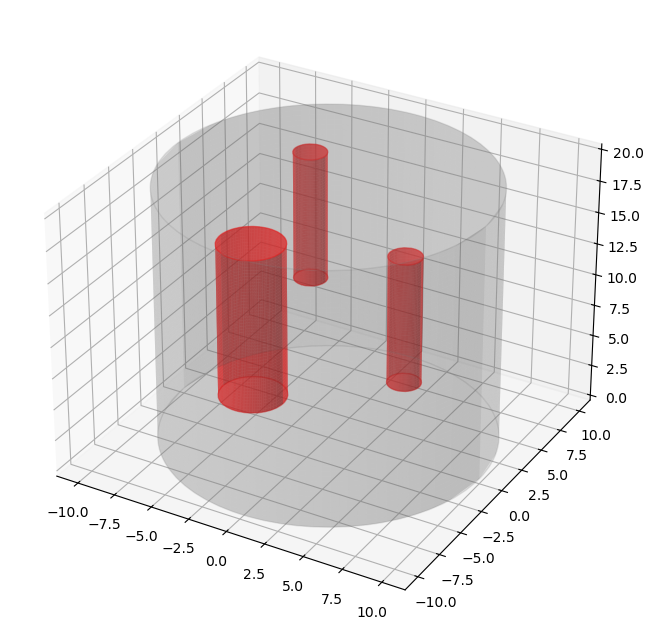

In [4]:
supercylinder = Cylinder(radius=10, height=20, radial_posn=0, angular_posn=0, axial_posn=0)
C1 = Cylinder(radius=1, height=10, radial_posn=5, angular_posn=0, axial_posn=6)
C2 = Cylinder(radius=1, height=10, radial_posn=4, angular_posn=3*np.pi/4, axial_posn=10)
C3 = Cylinder(radius=2, height=12, radial_posn=5, angular_posn=4*np.pi/3, axial_posn=5)
supercylinder.add_subunits([C1, C2, C3])

fig = plt.figure(figsize=(8,16))
ax = fig.add_subplot(projection='3d')

supercylinder.plot_surface(ax, alpha=0.2, color="gray")

for c in supercylinder.subunits:
    c.plot_surface(ax, alpha=0.5, color="red")
    
plt.show()

In [13]:
class Circle():
    def __init__(self, radius=None, radial_posn=None, angular_posn=None, subunits=None):
        self.radius = radius
        self.radial_posn = radial_posn
        self.angular_posn = angular_posn
        if subunits is not None:
            self.subunits = subunits
        else:
            self.subunits = []
        if self.radius is not None:
            self.area = np.pi * self.radius**2
        else:
            self.area = None
        if self.radial_posn is not None and self.angular_posn is not None:
            self.x = self.radial_posn * np.cos(self.angular_posn)
            self.y = self.radial_posn * np.sin(self.angular_posn)
        else:
            self.x = None
            self.y = None
        
    def set_radius(self, R):
        self.radius = R
    
    def set_radial_posn(self, r):
        self.radial_posn = r
        if self.angular_posn is not None and self.x is None and self.y is None:
            self.x = self.radial_posn * np.cos(self.angular_posn)
            self.y = self.radial_posn * np.sin(self.angular_posn)
        
    def set_angular_posn(self, theta):
        self.angular_posn = theta
        if self.radial_posn is not None and self.x is None and self.y is None:
            self.x = self.radial_posn * np.cos(self.angular_posn)
            self.y = self.radial_posn * np.sin(self.angular_posn)
            
    def radial_overlap(self, C):
        return (self.radial_posn - self.radius < C.radial_posn - C.radius < self.radial_posn + self.radius
                or self.radial_posn - self.radius < C.radial_posn + C.radius < self.radial_posn + self.radius
                or C.radial_posn - C.radius < self.radial_posn - self.radius < C.radial_posn + C.radius
                or C.radial_posn - C.radius < self.radial_posn + self.radius < C.radial_posn + C.radius)
    
    def angular_overlap(self, C):
        dist = math.sqrt( (self.x - C.x)**2 + (self.y - C.y)**2 )
        return (dist <= self.radius - C.radius
                or dist <= C.radius - self.radius
                or dist < self.radius + C.radius
                or dist == self.radius + C.radius)
        
    def add_subunits(self, S: list):
        for unit in S:
            if len(self.subunits) == 0:
                self.subunits.append(unit)
            elif unit.radial_posn + unit.radius <= self.radius \
            and not any([unit.angular_overlap(other_unit) for other_unit in self.subunits]):
                self.subunits.append(unit)
    
    def pack(self, num_attempts=10):
        attempts = 1
        while attempts <= num_attempts:
            new_radius = 1 #random.uniform(0.5, 2)
            new_unit = Circle(radius=new_radius, radial_posn=random.uniform(0, self.radius - new_radius), angular_posn=random.uniform(0, 2*np.pi))
            self.add_subunits([new_unit])
            attempts += 1

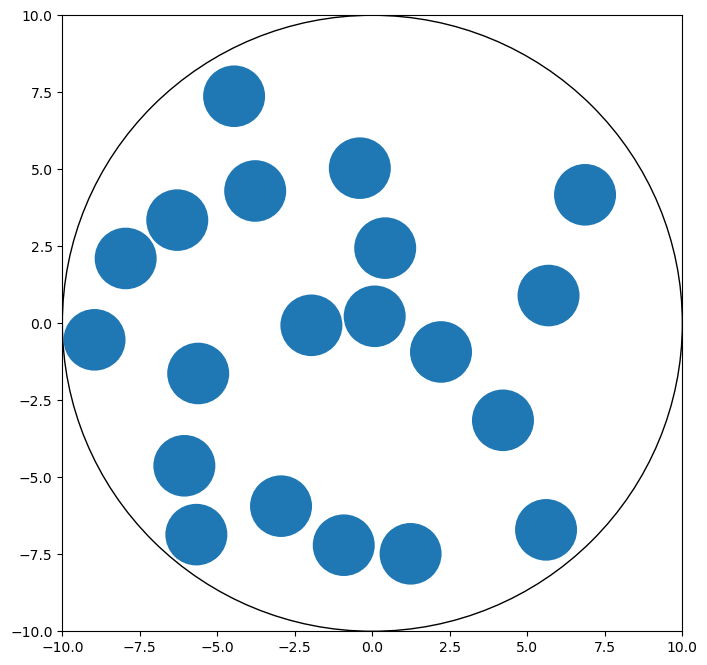

In [18]:
random.seed(42)
supercircle = Circle(radius=10, radial_posn=0, angular_posn=0)
#C1 = Circle(radius=1, radial_posn=5, angular_posn=0)
#C2 = Circle(radius=1, radial_posn=4, angular_posn=np.pi)
#C3 = Circle(radius=2, radial_posn=5, angular_posn=4*np.pi/3)
supercircle.pack(num_attempts=50)

fig, ax = plt.subplots(figsize=(8,8))

mpl_supercircle = plt.Circle((supercircle.x, supercircle.y), supercircle.radius, fill=False)
ax.add_patch(mpl_supercircle)

for c in supercircle.subunits:
    mpl_c = plt.Circle((c.x, c.y), c.radius)
    ax.add_patch(mpl_c)
    
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
    
plt.show()

C:\Users\freja\AppData\Local\Temp\ipykernel_29332\753874596.py:97: RuntimeWarning: invalid value encountered in sqrt
  Y = np.sqrt(self.radius**2 - (X - self.x)**2) + self.y


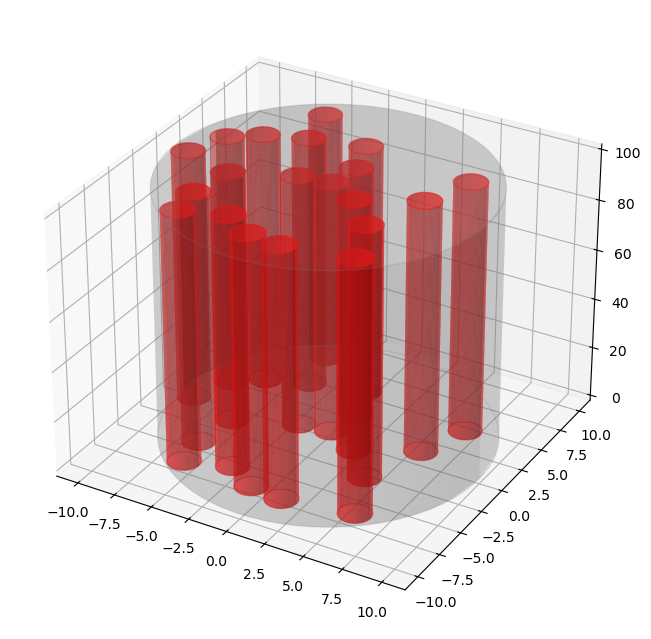

In [19]:
random.seed(42)
container = Cylinder(radius=supercircle.radius, height=100, radial_posn=0, angular_posn=0, axial_posn=0)

fig = plt.figure(figsize=(8,16))
ax = fig.add_subplot(projection='3d')

container.plot_surface(ax, alpha=0.2, color="gray")

for unit in supercircle.subunits:
    C = Cylinder(radius=unit.radius, height=container.height, radial_posn=unit.radial_posn, angular_posn=unit.angular_posn, axial_posn=0)
    C.plot_surface(ax, alpha=0.5, color="red")
    
plt.show()

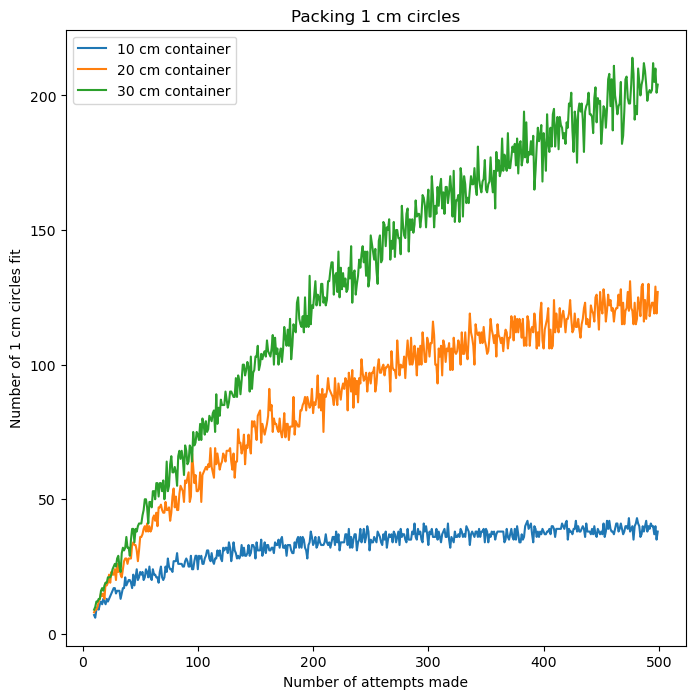

In [8]:
random.seed(42)
fig, ax = plt.subplots(figsize=(8,8))

for r in [10, 20, 30]:
    sizes = []
    attempts = []
    for i in range(10, 500):
        supercircle = Circle(radius=r, radial_posn=0, angular_posn=0)
        supercircle.pack(num_attempts=i)
        attempts.append(i)
        sizes.append(len(supercircle.subunits))
    ax.plot(attempts, sizes, label="{} cm container".format(r))
    
ax.set_title("Packing 1 cm circles")
ax.set_ylabel("Number of 1 cm circles fit")
ax.set_xlabel("Number of attempts made")
ax.legend()
plt.show()

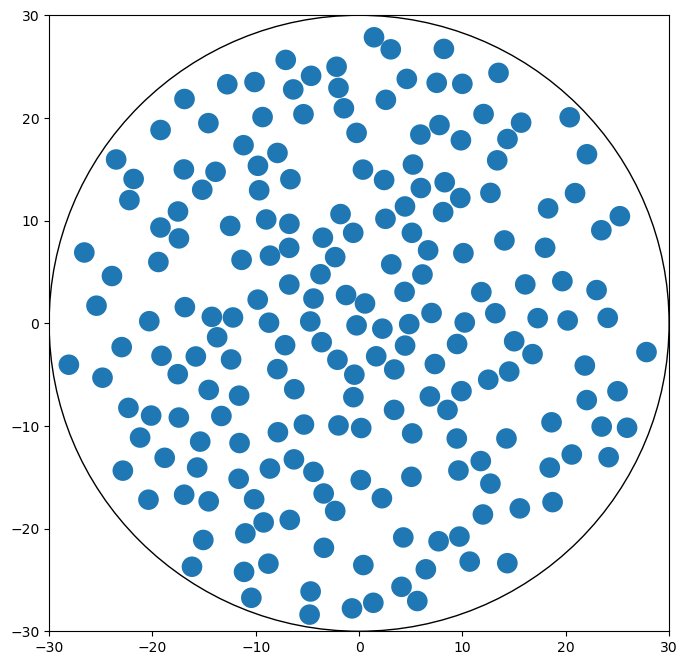

In [9]:
random.seed(42)
fig, ax = plt.subplots(figsize=(8,8))

mpl_supercircle = plt.Circle((supercircle.x, supercircle.y), supercircle.radius, fill=False)
ax.add_patch(mpl_supercircle)

for c in supercircle.subunits:
    mpl_c = plt.Circle((c.x, c.y), c.radius)
    ax.add_patch(mpl_c)
    
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)
    
plt.show()

C:\Users\freja\AppData\Local\Temp\ipykernel_46072\4169022272.py:82: RuntimeWarning: invalid value encountered in sqrt
  Y = np.sqrt(self.radius**2 - (X - self.x)**2) + self.y


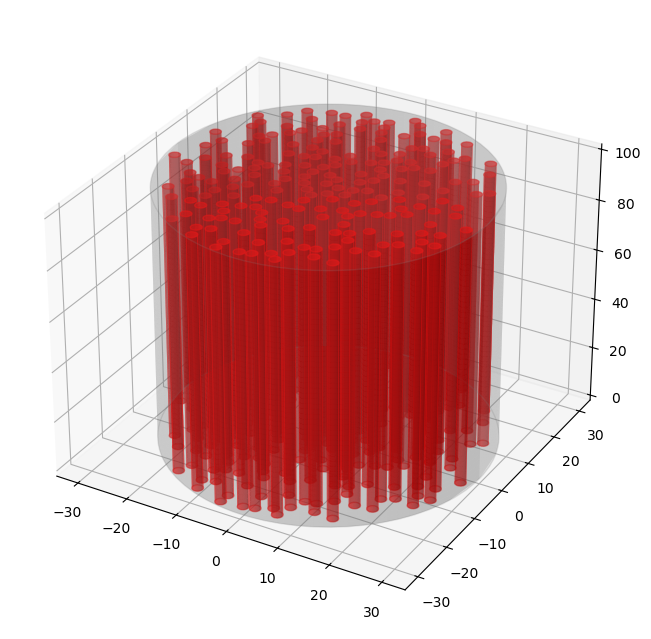

In [10]:
random.seed(42)
container = Cylinder(radius=supercircle.radius, height=100, radial_posn=0, angular_posn=0, axial_posn=0)

fig = plt.figure(figsize=(8,16))
ax = fig.add_subplot(projection='3d')

container.plot_surface(ax, alpha=0.2, color="gray")

for unit in supercircle.subunits:
    C = Cylinder(radius=unit.radius, height=container.height, radial_posn=unit.radial_posn, angular_posn=unit.angular_posn, axial_posn=0)
    C.plot_surface(ax, alpha=0.5, color="red")
    
plt.show()

In [7]:
random.seed(42)
# sample distribution of MT lengths known for current compartmental conditions

# based on Kuo et al.:
# Kuo, Y., Trottier, O., Mahamdeh, M., Howard, J. (2019). Spastin is a dual-function enzyme that severs microtubules and promotes their regrowth to increase the number and mass of microtubules. Biophysics aqnd Computational Biology, 116 (12) 5533-5541. https://doi.org/10.1073/pnas.1818824116
# approximately negative exponential distribution with mean 5.5 +- 4.4 um for tubulin-only assay, and approximately Poisson with lambda = 4 after 10 minutes of 50 nM spastin exposure
# for tubulin-only (319 total count), Kuo et al. appear to have an exponential fit which has values 28 and length = 0 um and 1 at length = 20 um, so I extrapolated the following parameters

kuo_base = 0.8465295026
kuo_coeff = 28/319
kuo_lower_limit = 0.103687

def kuo_tubulin_only_length_distribution(length):
    # sample between 1 and 20 um
    return kuo_coeff * np.exp( length * np.log(kuo_base) )

def sample_kuo(rand):
    return -np.log(rand/kuo_coeff)/np.log(kuo_base)

# based on Yu and Baas:
# Yu, W., & Baas, P. W. (1994). Changes in microtubule number and length during axon differentiation. The Journal of neuroscience : the official journal of the Society for Neuroscience, 14(5 Pt 1), 2818–2829. https://doi.org/10.1523/JNEUROSCI.14-05-02818.1994
# much sharper exponential

bincounts = [970, 220, 120, 60, 30, 20, 10]
bincenters = [2, 6, 10, 14, 18, 22, 26]

def exponential(length, a, k, b):
    return (a*np.exp(-length*k) + b)

popt_exp, pcov_exp = curve_fit(exponential, xdata=bincenters, ydata=bincounts)

yu_baas_a, yu_baas_k, yu_baas_b = popt_exp
yu_baas_a /= 1430
yu_baas_b /= 1430
yu_baas_lower_limit = yu_baas_b + 0.000001

def sample_Yu_Baas(rand):
    return -np.log((rand - yu_baas_b)/yu_baas_a)/yu_baas_k

print(yu_baas_a)
print(yu_baas_b)
print(yu_baas_k)

1.3867234911412691
0.02271689815195462
0.3758214593880463


C:\Users\freja\AppData\Local\Temp\ipykernel_42168\1708109384.py:28: RuntimeWarning: overflow encountered in exp
  return (a*np.exp(-length*k) + b)


In [8]:
random.seed(42)
# https://doi.org/10.1073/pnas.1818824116
growth_rate = lambda tubulin_concentration: 0.71 / 60 # 0.71 +- 0.12 um/min in tubulin-only control experiment, 0.79 +- 0.15 with 50 nM spastin
shrink_rate = lambda tubulin_concentration: 15.8 / 60 # 15.8 +- 5.1 um/min in tubulin-only control experiment, 9.9 +- 4.3 with 50 nM spastin
rescue_rate = lambda MAP_concentrations, length: 0.43 / 60 # 0.43 +- 0.02 rescues per minute in tubulin-only control experiment, 3.12 +- 0.45 with 50 nM spastin
catastrophe_rate = lambda MAP_concentrations, length: 0.098 / 60 # 0.098 to 0.002 catastrophes per minute in tubulin-only control experiment, same with 50 nM spastin
# this study used 50 nM spastin because it is close to the cellular concentration in developing rat neuronal tissue (50-100 nM)

# 50 nM spastin:
#growth_rate = lambda tubulin_concentration: 0.45 / 60 # um/s
#shrink_rate = lambda tubulin_concentration: 3.1 / 60 # um/s
#rescue_rate = lambda MAP_concentrations, length: 0.33 / 60 # hZ
#catastrophe_rate = lambda MAP_concentrations, length: 0.055 / 60 # hZ

# microtubule macromolecule within a subcompartment of an axon compartment
class Microtubule(Cylinder):
    # @params
    # radius: 12-14 nm Ledbetter MC, Porter KR (1963). "A "microtubule" in plant cell fine structure". Journal of Cell Biology. 19 (1): 239–50. doi:10.1083/jcb.19.1.239. PMC 2106853. PMID 19866635.
    # length (height): sampling the distributions reported in Kuo et al. 2019, although some say up to 50 um https://doi.org/10.1073/pnas.0603931103
    # phase: "growing" or "shrinking"
    #    in the future, incorporate two phase variables so plus and minus ends can change simultaneously
    # half-life (s^-1) = random.randint(5, 10)*60: 5 to 10 minutes Kirschner M, Mitchison T (May 1986). "Beyond self-assembly: from microtubules to morphogenesis". Cell. 45 (3): 329–42. doi:10.1016/0092-8674(86)90318-1. PMID 3516413. S2CID 36994346.
    def __init__(self, phase=None, radius=random.randint(12, 14)/1000, height=sample_kuo(random.uniform(kuo_lower_limit, 1)), **kwargs):
        super().__init__(radius=random.randint(12, 14)/1000, height=sample_kuo(random.uniform(kuo_lower_limit, 1)), **kwargs)
        # for now, all minus ends are fixed and all plus ends are collinear. this fits with Kuo et al.'s Fig 4 description of the canonical dynamic instability model
        self.phase = phase # in the future, incorporate two phase variables so plus and minus ends can change simultaneously
        if self.phase is None:
            # pretend this MT's plus end is in a "neutral state" and will spontaneously undergo a rescue or catastrophe event upon creation
            if random.uniform(0, 1) < rescue_rate(None, None) / (rescue_rate(None, None) + catastrophe_rate(None, None)):
                self.phase = "growing"
            else:
                self.phase = "shrinking"
        
    def grow(self, tstep, tubulin_conc=None):
        self.height += growth_rate(tubulin_conc)*tstep
        
    def shrink(self, tstep, tubulin_conc=None):
        self.height -= shrink_rate(tubulin_conc)*tstep
        
    def update_phase(self, tstep, MAP_conc=None):
        R = random.uniform(0, 1)
        if self.phase == "growing":
            if R < catastrophe_rate(MAP_conc, self.height)*tstep:
                self.phase = "shrinking"
        elif self.phase == "shrinking":
            if R < rescue_rate(MAP_conc, self.height)*tstep:
                self.phase == "growing"
        
    def update_height(self, tstep, tubulin_conc=None, MAP_conc=None):
        self.update_phase(tstep, MAP_conc)
        if self.phase == "growing":
            self.grow(tstep, tubulin_conc)
        elif self.phase == "shrinking":
            self.shrink(tstep, tubulin_conc)
            
    def cut(self, cut_axial_posn):
        upper = Microtubule(phase=self.phase, radius=self.radius, height=self.height - cut_axial_posn, radial_posn=self.radial_posn, angular_posn=self.angular_posn, axial_posn=cut_axial_posn)
        lower = Microtubule(phase="shrinking", radius=self.radius, height=cut_axial_posn - self.axial_posn, radial_posn=self.radial_posn, angular_posn=self.angular_posn, axial_posn=self.axial_posn)
        return upper, lower
    
    def is_hit(self, hit_radial_posn, hit_angular_posn, hit_axial_posn):
        dist = math.sqrt( (self.x - hit_radial_posn*np.cos(hit_angular_posn))**2 + (self.y - hit_radial_posn*np.sin(hit_angular_posn))**2 )
        return (dist < self.radius and self.axial_posn < hit_axial_posn < self.axial_posn + self.height)
    
            
# cylindrical neurite compartment
class Compartment(Cylinder):
    # @params
    # radius: 0.5 um for axons
    # length (height: 56 um for axons
        # Yu, W., & Baas, P. W. (1994). Changes in microtubule number and length during axon differentiation. The Journal of neuroscience : the official journal of the Society for Neuroscience, 14(5 Pt 1), 2818–2829. https://doi.org/10.1523/JNEUROSCI.14-05-02818.1994
    # tubulin_conc: find source
    # MAP_conc: find source
    def __init__(self, tubulin_conc=None, MAP_conc=None, **kwargs):
        super().__init__(**kwargs)
        self.tubulin_conc = tubulin_conc
        self.MAP_conc = MAP_conc
        
    def pack_microtubules(self, num_attempts=10, length_function=None, length_function_lower_limit=None):
        attempts = 1
        while attempts <= num_attempts:
            new_radius = random.randint(12, 14)/1000
            if length_function is not None:
                if length_function_lower_limit is not None:
                    new_height = length_function(random.uniform(length_function_lower_limit, 1))
                else:
                    new_height = length_function(random.uniform(0, 1))
            else:
                new_height = sample_kuo(random.uniform(kuo_lower_limit, 1))
            new_unit = Microtubule(radius=new_radius, height=new_height,
                                   radial_posn=random.uniform(0, self.radius - new_radius),
                                   angular_posn=random.uniform(0, 2*np.pi),
                                   axial_posn=random.uniform(0, self.height - new_height))
            self.add_subunits([new_unit])
            attempts += 1
    
    def simulate_hits(self, hit_posns: list):
        hit_indices = []
        new_MTs = []
        for hit_posn in hit_posns:
            for i, MT in enumerate(self.subunits):
                if MT.is_hit(*hit_posn):
                    hit_indices.append(i)
                    upper, lower = MT.cut(hit_posn[2])
                    new_MTs += [upper, lower]
                    break
        self.subunits = [self.subunits[i] for i in range(len(self.subunits)) if i not in hit_indices]
        self.subunits.add_subunits(new_MTs)
    
    def simulate_kinetics(self, nsteps, simulation_time):
        tstep = simulation_time/nsteps
        compartment_heights = [self.height]
        MT_heights = [[MT.height for MT in self.subunits]]
        mean_MT_heights = [sum(MT_heights[0])/len(MT_heights[0])]
        lifetimes = {i: 0 for i in [unit.objid for unit in self.subunits]} # seconds
        for step in range(nsteps):
            for i, MT in enumerate(self.subunits):
                MT.update_height(tstep, tubulin_conc=self.tubulin_conc, MAP_conc=self.MAP_conc)
                self.subunits[i] = MT
                lifetimes[MT.objid] += tstep
            self.subunits = [MT for MT in self.subunits if MT.height > 0]
            try:
                max_tip_posn = max([MT.axial_posn + MT.height for MT in self.subunits])
                if max_tip_posn > self.height or max_tip_posn < self.height:
                    self.height = max_tip_posn
                compartment_heights.append(self.height)
                new_MT_heights = [MT.height for MT in self.subunits]
                MT_heights.append(new_MT_heights)
                mean_MT_heights.append(sum(new_MT_heights)/len(new_MT_heights))
            except Exception as e:
                print("Microtubule population is empty at step {}.".format(step))
                break
            
        return MT_heights, mean_MT_heights, compartment_heights, lifetimes
    
    def plot_kinetics_x3(self, nsteps, simulation_time):
        _g = globals()
        init_height = self.height
        fig = plt.figure(figsize=(16,18))
        ax1 = fig.add_subplot(4, 3, 1, projection='3d')
        hax1 = fig.add_subplot(4, 3, 2)
        #sax1 = fig.add_subplot(4, 3, 3)
        self.plot_surface(ax1, alpha=0.2, color="gray")
        for MT in self.subunits:
            MT.plot_surface(ax1, alpha=0.5, color="red")
        ax1.set_title("Microtubules at t=0")
        ax1.set_zlim(0, max([MT.axial_posn + MT.height for MT in self.subunits]))
        _, bins, _ = hax1.hist([MT.height for MT in self.subunits], range=[0, init_height], color="red")
        hax1.set_title("Microtubule Lengths at t=0")
        hax1.set_ylabel("Number of Microtubules")
        hax1.set_xlabel("Length (um)")
        for i in range(2, 5):
            MT_heights, mean_MT_heights, compartment_heights, lifetimes = self.simulate_kinetics(int(nsteps/3), simulation_time/3)
            _g["ax{}".format(i)] = fig.add_subplot(4, 3, 3*i - 2, projection='3d')
            _g["hax{}".format(i)] = fig.add_subplot(4, 3, 3*i - 1)
            _g["sax{}".format(i)] = fig.add_subplot(4, 3, 3*i)
            self.plot_surface(_g["ax{}".format(i)], alpha=0.2, color="gray")
            for MT in self.subunits:
                MT.plot_surface(_g["ax{}".format(i)], alpha=0.5, color="red")
            _ = _g["hax{}".format(i)].hist(MT_heights[i - 1], range=[0, init_height], bins=bins, color="red")
            _g["ax{}".format(i)].set_title("Microtubules at t={} s".format(round((i - 1)*simulation_time/3,3)))
            _g["hax{}".format(i)].set_title("Microtubule Lengths at t={} s".format(round((i - 1)*simulation_time/3,3)))
            _g["hax{}".format(i)].set_ylabel("Number of Microtubules")
            _g["hax{}".format(i)].set_xlabel("Length (um)")
            t_low = int((i - 2)*simulation_time/3)
            t_high = int((i - 1)*simulation_time/3)
            _g["sax{}".format(i)].plot([i*simulation_time/nsteps for i in range(t_low, t_low + int(nsteps/3))], compartment_heights[:int(nsteps/3)])
            _g["sax{}".format(i)].set_title("Compartment Length")
            _g["sax{}".format(i)].set_ylabel("Length (um)")
            _g["sax{}".format(i)].set_xlabel("Time (s)")
        plt.show()

In [ ]:
# PyTorch tensorized microtubule packing

import torch
import time
from torch import distributions
d = torch.distributions.Uniform(torch.tensor([0.0]), torch.tensor([1.0]))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.random.manual_seed(42)

def pack(N_MTs):
    

def attempt_pack(N_MTs):
    # initial x,y,z1 (center of base); z2 (z of top); radius
    r = torch.rand((5, MTs)).to(device)

def pack_torch(N_MTs):
    r = torch.rand((5, N_MTs)).to(device)
    r[:,3] = r[:,3] * (1 - (0.000001 + 0.02271689815195462)) + (0.000001 + 0.02271689815195462) # acceptable height sampling limits
    posns = torch.empty_like(r)
    posns[:,0] = 2 * self.radius * r[:,0] - self.radius # x
    posns[:,1] = 2 * self.radius * r[:,1] - self.radius # y
    posns[:,3] = -torch.log((r[:,3] - 0.02271689815195462)/1.3867234911412691) / 0.3758214593880463 # height
    posns[:,2] = r[:,2] * (self.height - posns[:,3]) # z (axial_posn)
    posns[:,4] = 14 - 2 * r[:,4] # radius
    
    # for checking if current subunits overlap:
    #posns = torch.tensor([(m.x, m.y, m.z, m.z + m.height, m.radius) for m in self.subunits])
    ids = torch.arange(N_MTs)#len(self.subunits))
    ids_pairs = torch.combinations(ids, 2).to(device)
    
    x_pairs = torch.stack([posns[0][ids_pairs[:,0]], posns[0][ids_pairs[:,1]]]).T
    y_pairs = torch.stack([posns[1][ids_pairs[:,0]], posns[1][ids_pairs[:,1]]]).T
    z_pairs = torch.stack([posns[2][ids_pairs[:,0]], posns[2][ids_pairs[:,1]]]).T
    h_pairs = torch.stack([posns[3][ids_pairs[:,0]], posns[3][ids_pairs[:,1]]]).T
    zh_pairs = torch.stack([posns[2][ids_pairs[:,0]], posns[3][ids_pairs[:,1]]])
    r_pairs = torch.stack([posns[4][ids_pairs[:,0]], posns[4][ids_pairs[:,1]]]).T
    
    dx_pairs = torch.diff(x_pairs, axis=1).ravel()
    dy_pairs = torch.diff(y_pairs, axis=1).ravel()
    d_pairs = torch.sqrt(dx_pairs**2, dy_pairs**2)
    
    dz_pairs = torch.diff(z_pairs, axis=1).ravel()
    dh_pairs = torch.diff(h_pairs, axis=1).ravel()
    dzh_pairs = torch.diff(zh_pairs, axis=1).ravel()
    
    sr_pairs = torch.sum(r_pairs, axis=1).ravel()
    
    ids_pairs_radial_overlap = ids_pairs[d_pairs < sr_pairs]
    ids_pairs_axial_overlap = ids_pairs[(dz_pairs > 0 & dzh_pairs < 0) | (dh_pairs < 0 & dzh_pairs > 0)]
    
    no_overlap = ids_pairs[(not ids_pairs_radial_overlap) & (not ids_pairs_axial_overlap)] # torch.neg(ids_pairs_radial_overlap)?
    
    # return parameters at indices that do not overlap with any other parameter set
    self.subunits.append([Cylinder(x=posn[0], y=posn[1], axial_posn=posn[2], height=posn[3], radius=posn[4], objid=i) for i, posn in enumerate(posns[no_overlap].numpy())])
        
        

container = Cylinder(radius=0.5, height=56, x=0, y=0, radial_posn=0, angular_posn=0, axial_posn=0)

Microtubule population is empty at step 4403.
Microtubule population is empty at step 8283.
Microtubule population is empty at step 3307.
Microtubule population is empty at step 8113.


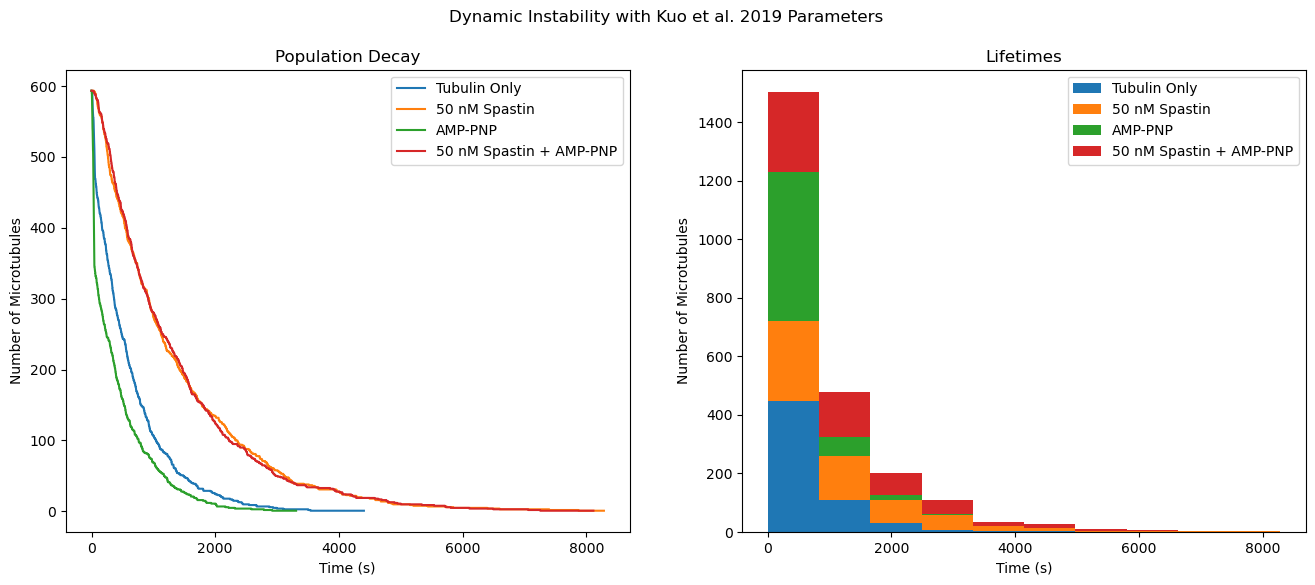

In [27]:
fig, (hax, lax) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

nsteps = 9000
simulation_time = 9000

# just tubulin
growth_rate = lambda tubulin_concentration: 0.71 / 60
shrink_rate = lambda tubulin_concentration: 15.8 / 60
rescue_rate = lambda MAP_concentrations, length: 0.43 / 60
catastrophe_rate = lambda MAP_concentrations, length: 0.098 / 60

random.seed(42)
container = Compartment(radius=0.5, height=56, radial_posn=0, angular_posn=0, axial_posn=0)
container.pack_microtubules(num_attempts=1000)
MT_heights, mean_MT_heights, compartment_heights, lifetimes1 = container.simulate_kinetics(nsteps, simulation_time)
hax.plot(range(len(MT_heights)), [len(heights) for heights in MT_heights], label="Tubulin Only")

# 50 nM spastin
growth_rate = lambda tubulin_concentration: 0.45 / 60 # um/s
shrink_rate = lambda tubulin_concentration: 3.1 / 60 # um/s
rescue_rate = lambda MAP_concentrations, length: 0.33 / 60 # hZ
catastrophe_rate = lambda MAP_concentrations, length: 0.055 / 60 # hZ

random.seed(42)
container = Compartment(radius=0.5, height=56, radial_posn=0, angular_posn=0, axial_posn=0)
container.pack_microtubules(num_attempts=1000)
MT_heights, mean_MT_heights, compartment_heights, lifetimes2 = container.simulate_kinetics(nsteps, simulation_time)
hax.plot(range(len(MT_heights)), [len(heights) for heights in MT_heights], label="50 nM Spastin")

# AMP-PNP
growth_rate = lambda tubulin_concentration: 0.7 / 60
shrink_rate = lambda tubulin_concentration: 19.8 / 60
rescue_rate = lambda MAP_concentrations, length: 0.19 / 60
catastrophe_rate = lambda MAP_concentrations, length: 0.11 / 60

random.seed(42)
container = Compartment(radius=0.5, height=56, radial_posn=0, angular_posn=0, axial_posn=0)
container.pack_microtubules(num_attempts=1000)
MT_heights, mean_MT_heights, compartment_heights, lifetimes3 = container.simulate_kinetics(nsteps, simulation_time)
hax.plot(range(len(MT_heights)), [len(heights) for heights in MT_heights], label="AMP-PNP")

# 50 nM Spastin + AMP-PNP
growth_rate = lambda tubulin_concentration: 0.7 / 60
shrink_rate = lambda tubulin_concentration: 5.1 / 60
rescue_rate = lambda MAP_concentrations, length: 1.36 / 60
catastrophe_rate = lambda MAP_concentrations, length: 0.054 / 60

random.seed(42)
container = Compartment(radius=0.5, height=56, radial_posn=0, angular_posn=0, axial_posn=0)
container.pack_microtubules(num_attempts=1000)
MT_heights, mean_MT_heights, compartment_heights, lifetimes4 = container.simulate_kinetics(nsteps, simulation_time)
hax.plot(range(len(MT_heights)), [len(heights) for heights in MT_heights], label="50 nM Spastin + AMP-PNP")
lax.hist([list(l.values()) for l in [lifetimes1, lifetimes2, lifetimes3, lifetimes4]], stacked=True)

hax.legend()
hax.set_title("Population Decay")
hax.set_xlabel("Time (s)")
hax.set_ylabel("Number of Microtubules")

lax.legend(labels=["Tubulin Only", "50 nM Spastin", "AMP-PNP", "50 nM Spastin + AMP-PNP"])
lax.set_title("Lifetimes")
lax.set_xlabel("Time (s)")
lax.set_ylabel("Number of Microtubules")

fig.suptitle("Dynamic Instability with Kuo et al. 2019 Parameters")

#ax.hist(lifetimes.values())
plt.show()

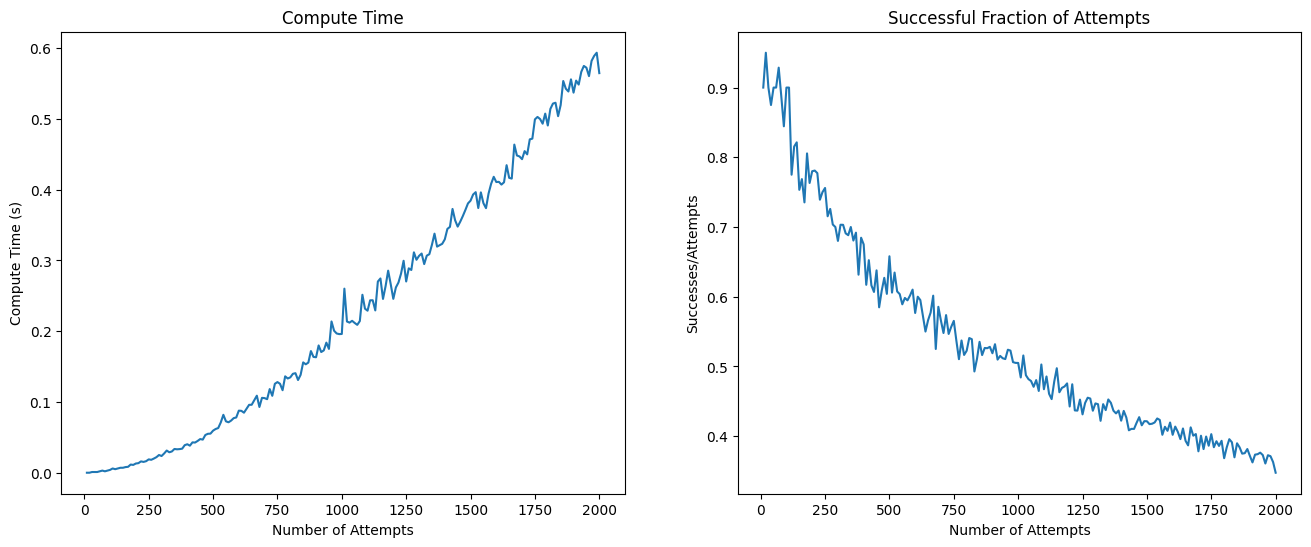

In [18]:
random.seed(42)
import time

# axon diameter ~1 um
# Graf von Keyserlingk, D., & Schramm, U. (1984). Diameter of axons and thickness of myelin sheaths of the pyramidal tract fibres in the adult human medullary pyramid. Anatomischer Anzeiger, 157(2), 97–111.
compute_time = []
successes = []
target_nums = [(i+1)*10 for i in range(200)]
for num in target_nums:
    container = Compartment(radius=0.5, height=40, radial_posn=0, angular_posn=0, axial_posn=0)
    start = time.time()
    container.pack_microtubules(num_attempts=num)
    end = time.time()
    compute_time.append(end - start)
    successes.append(len(container.subunits))

success_fractions = [s/n for s, n in zip(successes, target_nums)]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
axs[0].plot(target_nums, compute_time)
axs[0].set_title("Compute Time")
axs[0].set_ylabel("Compute Time (s)")
axs[0].set_xlabel("Number of Attempts")
axs[1].plot(target_nums, success_fractions)
axs[1].set_title("Successful Fraction of Attempts")
axs[1].set_ylabel("Successes/Attempts")
axs[1].set_xlabel("Number of Attempts")
plt.show()
#fig = plt.figure(figsize=(8,16))
#ax = fig.add_subplot(projection='3d')

#container.plot_surface(ax, alpha=0.2, color="gray")

#for c in container.subunits:
#    c.plot_surface(ax, alpha=0.5, color="red")
    
#plt.show()

#T = 120 # seconds
#nsteps = 120
#container.simulate_kinetics(nsteps=nsteps, simulation_time=T)
#container.plot_kinetics_x3(nsteps=nsteps, simulation_time=T)

C:\Users\freja\AppData\Local\Temp\ipykernel_35540\753874596.py:97: RuntimeWarning: invalid value encountered in sqrt
  Y = np.sqrt(self.radius**2 - (X - self.x)**2) + self.y


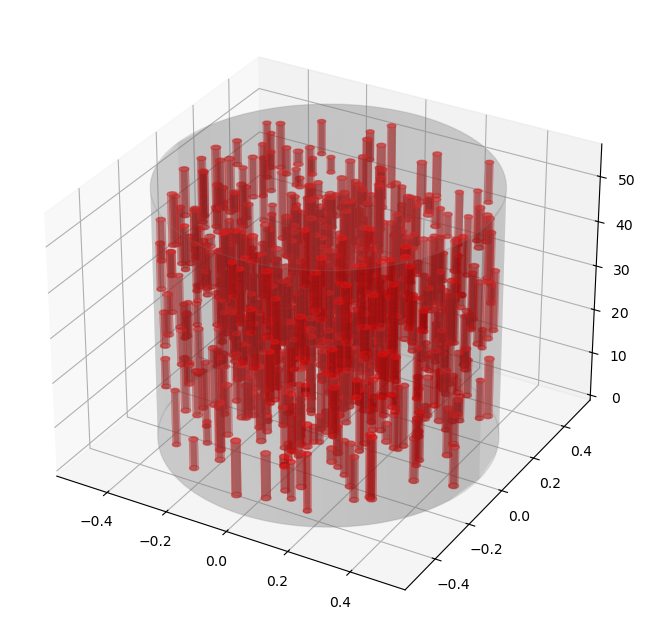

In [8]:
random.seed(42)
# try to recreate:
# Yu, W., & Baas, P. W. (1994). Changes in microtubule number and length during axon differentiation. The Journal of neuroscience : the official journal of the Society for Neuroscience, 14(5 Pt 1), 2818–2829. https://doi.org/10.1523/JNEUROSCI.14-05-02818.1994
# - hippocampal neurons in culture extend 20 um long minor processes; the first minor processes grow ~10 um longer than others will continue to grow rapidly and become the axon
# - in one minor process that hadn't formed an axon yet, there were 182 MTs ranging 0.14 to 20.09 um, average 3.87 +- 3.83 um; total MT length 704 um
# - in one minor process in a cell that had formed an axon, there were 157 MTs ranging 0.24 to 17.95 um, average 3.91 +- 4.84 um; total MT length 600 um
# - in a 56 um axon, there were 1430 MTs ranging 0.05 to 40.14 um, average 4.02 +- 5.28 um; total MT length 5750 um
# full: https://www.jneurosci.org/content/jneuro/14/5/2818.full.pdf

num_attempts = 1000
axon_length = 56 # um
axon_radius = 0.5 # um

container = Compartment(radius=axon_radius, height=axon_length, radial_posn=0, angular_posn=0, axial_posn=0)
container.pack_microtubules(num_attempts=num_attempts, length_function=sample_Yu_Baas, length_function_lower_limit=yu_baas_lower_limit)

fig = plt.figure(figsize=(8,16))
ax = fig.add_subplot(projection='3d')

container.plot_surface(ax, alpha=0.2, color="gray")

for c in container.subunits:
    c.plot_surface(ax, alpha=0.5, color="red")
    
plt.show()

In [9]:
print("Number of MTs: {}".format(len(container.subunits)))
print("Total MT length: {}".format(sum([MT.height for MT in container.subunits])))

Number of MTs: 563
Total MT length: 5295.889233936757


C:\Users\freja\AppData\Local\Temp\ipykernel_35540\753874596.py:97: RuntimeWarning: invalid value encountered in sqrt
  Y = np.sqrt(self.radius**2 - (X - self.x)**2) + self.y


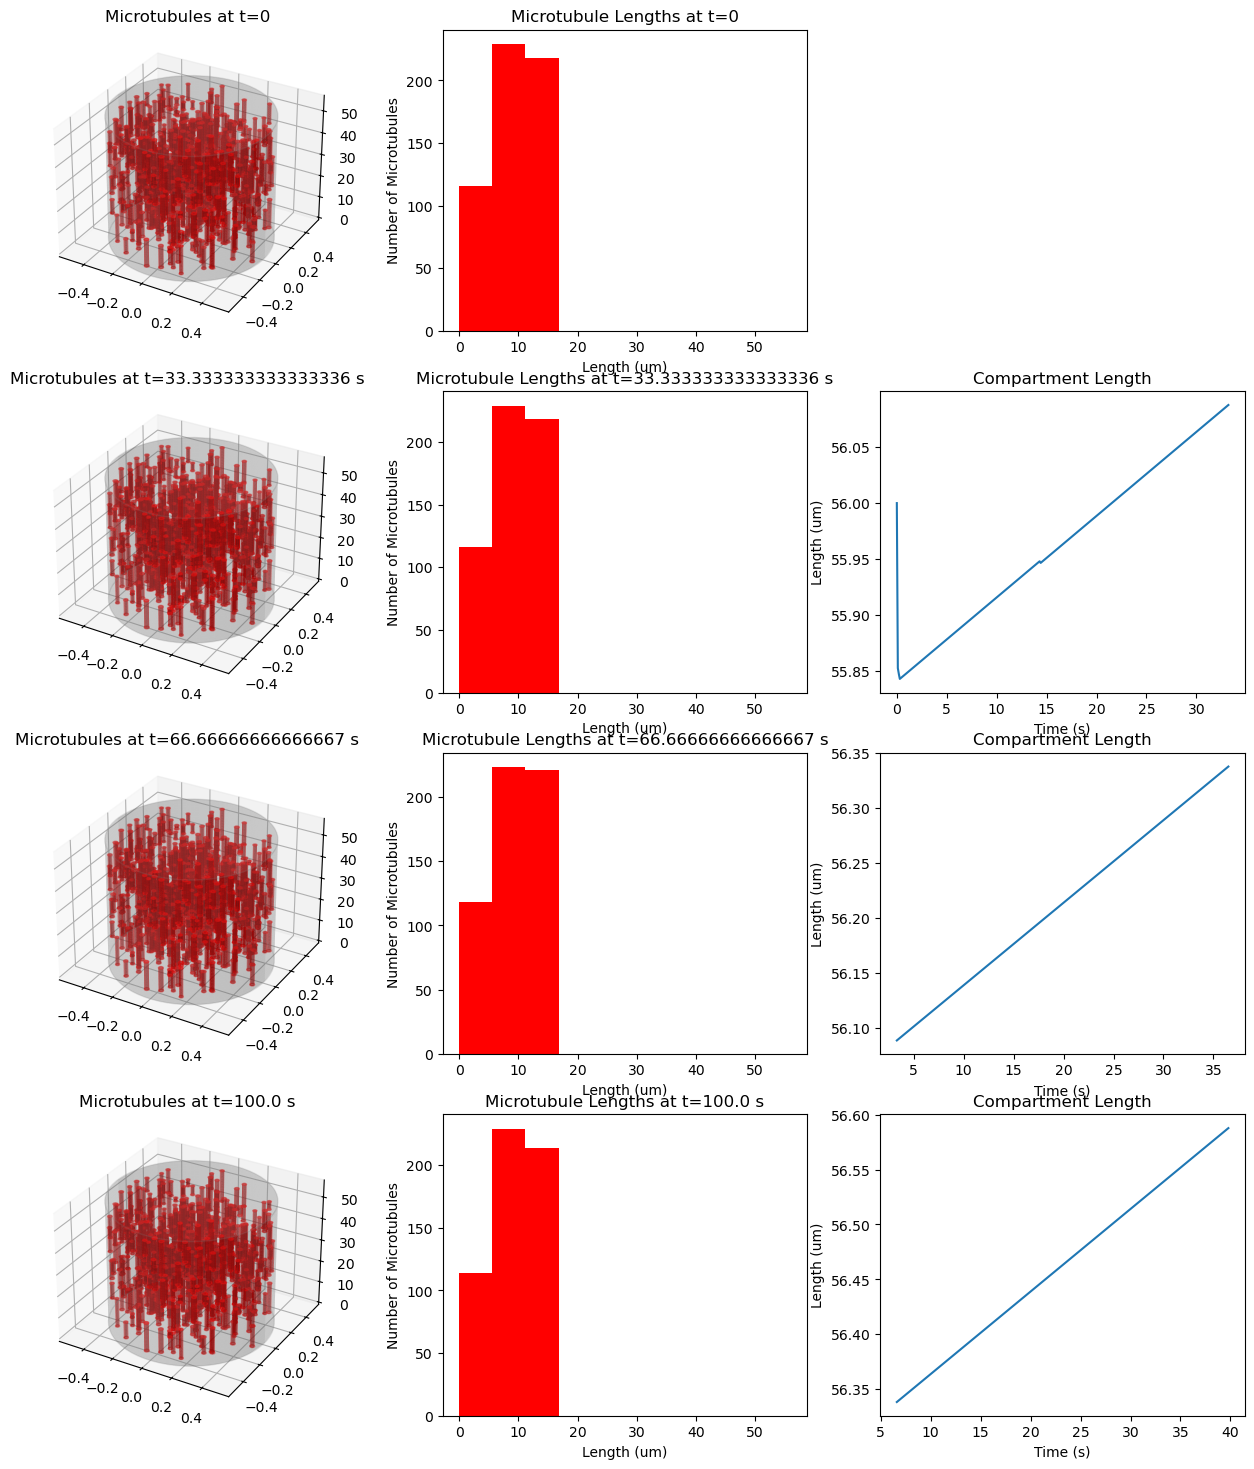

In [10]:
T = 900
nsteps = 9000
container.plot_kinetics_x3(nsteps=nsteps, simulation_time=T)

In [11]:
print("Number of MTs: {}".format(len(container.subunits)))
print("Total MT length: {}".format(sum([MT.height for MT in container.subunits])))

Number of MTs: 541
Total MT length: 5183.275856726767


C:\Users\freja\AppData\Local\Temp\ipykernel_28372\753874596.py:97: RuntimeWarning: invalid value encountered in sqrt
  Y = np.sqrt(self.radius**2 - (X - self.x)**2) + self.y


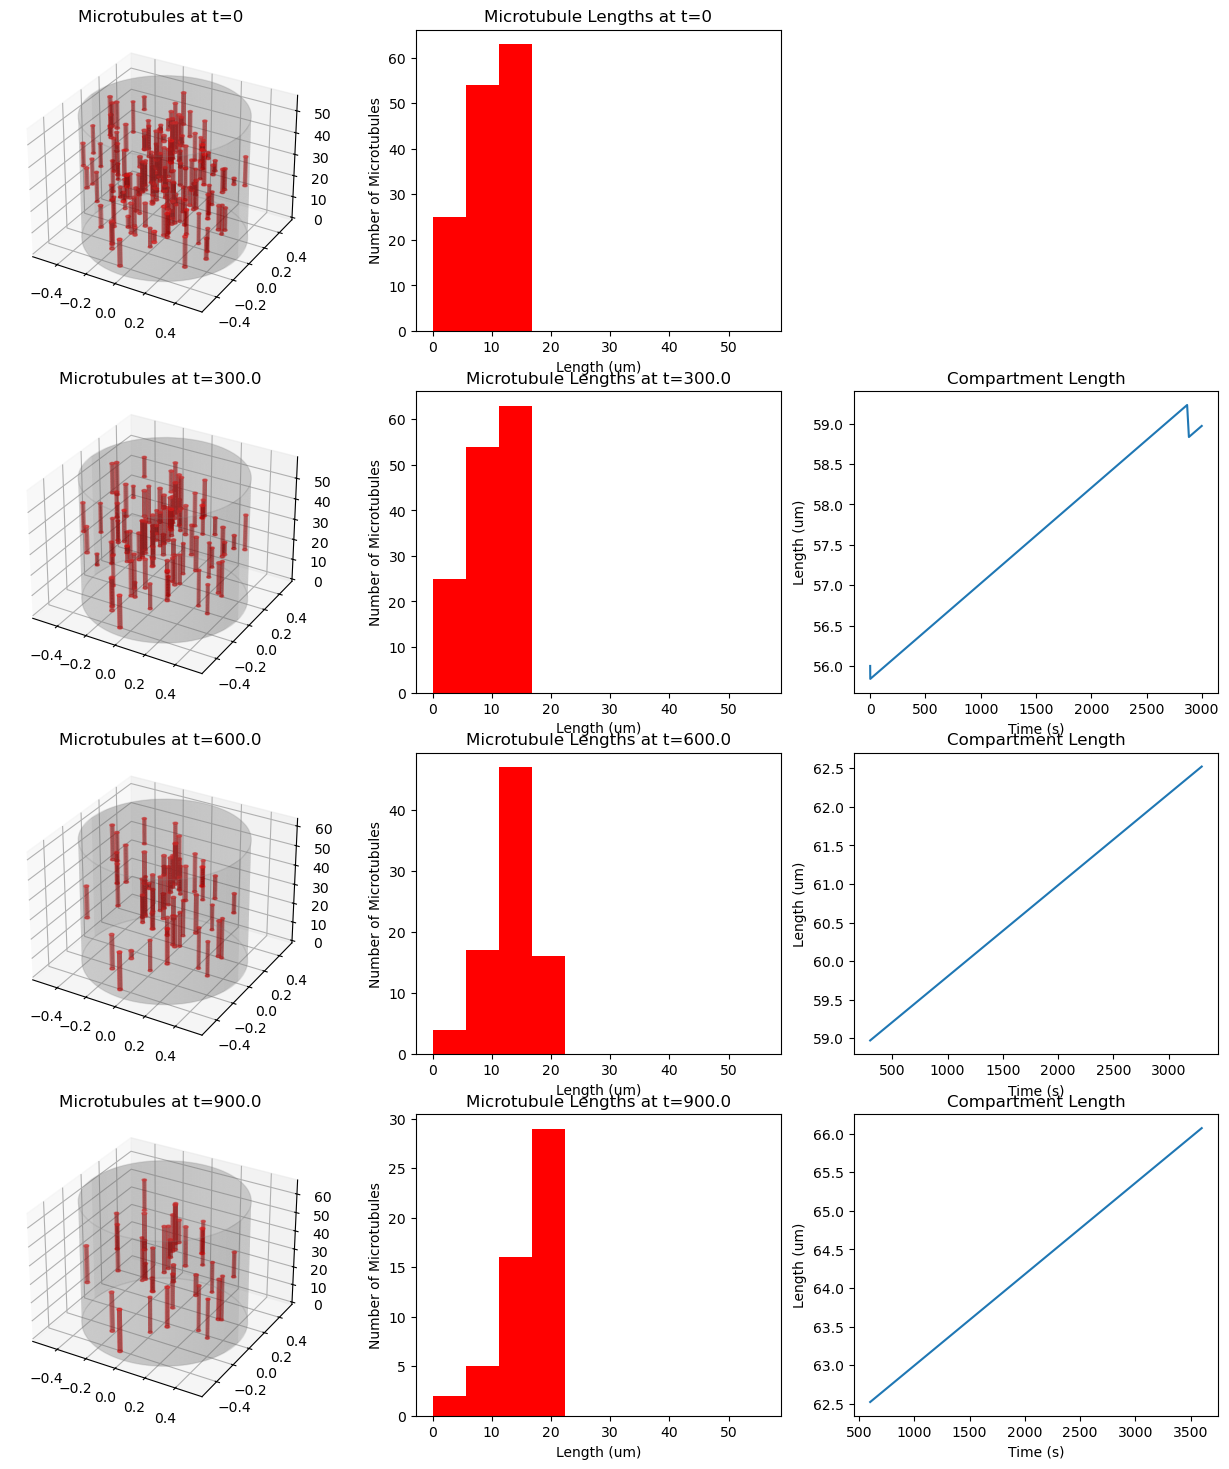

In [46]:
#random.seed(42)
num_attempts = 200
axon_length = 56 # um
axon_radius = 0.5 # um

container = Compartment(radius=axon_radius, height=axon_length, radial_posn=0, angular_posn=0, axial_posn=0)
container.pack_microtubules(num_attempts=num_attempts, length_function=sample_Yu_Baas, length_function_lower_limit=yu_baas_lower_limit)

T = 900
nsteps = 9000
container.plot_kinetics_x3(nsteps=nsteps, simulation_time=T)